In [1]:
from sklearn.linear_model import RidgeCV,LassoCV,Ridge,Lasso
from sklearn.svm import LinearSVR,SVR
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
#stacking    先用几个不同的模型做预测  输出预测值  然后将这几个模型输出的预测值作为特征来训练一个新的模型

## 获取数据

In [3]:
data=pd.read_csv("data/onehot_feature.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196499 entries, 0 to 196498
Data columns (total 40 columns):
时间           196499 non-null int64
小区名          196499 non-null int64
小区房屋出租数量     196499 non-null float64
楼层           196499 non-null int64
总楼层          196499 non-null float64
房屋面积         196499 non-null float64
房屋朝向         196499 non-null object
居住状态         196499 non-null float64
卧室数量         196499 non-null int64
厅的数量         196499 non-null int64
卫的数量         196499 non-null int64
出租方式         196499 non-null float64
区            196499 non-null float64
位置           196499 non-null float64
地铁线路         196499 non-null float64
地铁站点         196499 non-null float64
距离           196499 non-null float64
装修情况         196499 non-null float64
月租金          196499 non-null float64
log_rent     196499 non-null float64
新朝向          196499 non-null object
房+卫+厅        196499 non-null int64
房/总          196499 non-null float64
卫/总          196499 non-null float64
厅/总          1964

In [4]:
#将离散特征转换成字符串类型
colunms = ['时间', '新小区名', '居住状态', '出租方式', '区','位置','地铁线路','地铁站点','装修情况','户型','聚类特征']
for col in colunms:
    data[col] = data[col].astype(str)

In [5]:
x_columns=['小区房屋出租数量','新小区名', '楼层', '总楼层', '房屋面积','居住状态', '卧室数量',
       '卫的数量',  '位置',  '地铁站点', '距离', '装修情况', 
       '新朝向', '房+卫+厅', '房/总', '卫/总', '厅/总', '卧室面积', '楼层比', '户型','平均值特征1',
       '平均值特征2','有地铁','小区线路数','位置线路数','小区条数大于100','小区平均值特征','朝向平均值特征',
           '站点平均值特征','位置平均值特征']
y_label='log_rent'
x=data[x_columns]
y=data[y_label]

In [6]:
#2.分割数据集
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=12)

In [7]:
#3.特征转换
vector=DictVectorizer(sparse=True)
x_train=vector.fit_transform(train_x.to_dict(orient='records'))
x_test=vector.transform(test_x.to_dict(orient='records'))

In [8]:
x_train.shape

(137549, 964)

In [9]:
#4.降维----线性回归和svm可以采用降维后的特征
pca=PCA(0.98)
pca_x_train=pca.fit_transform(x_train.toarray())
pca_x_test=pca.transform(x_test.toarray())

In [10]:
pca_x_train.shape

(137549, 403)

In [11]:
#5.特征标准化
trans=StandardScaler()
new_x_train=trans.fit_transform(pca_x_train)
new_x_test=trans.transform(pca_x_test)

In [12]:
new_x_train.shape

(137549, 403)

In [13]:
# ploy=PolynomialFeatures(degree=2,interaction_only=True)
# ploy_x_train=ploy.fit_transform(new_x_train)
# ploy_x_test=ploy.transform(new_x_test)

In [14]:
# ploy_x_train.shape

In [15]:
def rmse(y_true,y_pred):
    y_pred=np.exp(y_pred)-1#转换成真实的租金
    y_true=np.exp(y_true)-1
    return np.sqrt(mean_squared_error(y_true,y_pred))

## 构建子模型
### 构建岭回归模型

In [16]:
#1.参数搜索
ridge=Ridge()
params={
    "alpha":[0.005,0.01,1,5,10,20,50],
    "fit_intercept":[True,False]
}
model1=GridSearchCV(ridge,param_grid=params,cv=5,n_jobs=-1)
model1.fit(new_x_train,train_y)
model1.best_params_   
#{'alpha': 50, 'fit_intercept': True}

{'alpha': 50}

In [17]:
#利用搜索出的最优参数构建模型
ridge=Ridge(alpha=50)
ridge.fit(new_x_train,train_y)


Ridge(alpha=50, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [18]:
y_pred_test=ridge.predict(new_x_test)
y_pred_train=ridge.predict(new_x_train)
print("训练集rmse：",rmse(train_y,y_pred_train))
print("测试集rmse：",rmse(test_y,y_pred_test))

训练集rmse： 3.1696222035801327
测试集rmse： 3.149308279156912


### 构建lasso回归

In [19]:
#1.参数搜索
lasso=Lasso()
params={
    "alpha":[0.001,0.01,0.05,0.1,0.5,1,5,10],
    "fit_intercept":[True,False] 
}
model2=GridSearchCV(lasso,param_grid=params,cv=5,n_jobs=-1)
model2.fit(new_x_train,train_y)
model2.best_params_
#{'alpha': 0.001, 'fit_intercept': True}

{'alpha': 0.001, 'fit_intercept': True}

In [20]:
#利用搜索出的最优参数构建模型
lasso=Lasso(alpha=0.001)
lasso.fit(new_x_train,train_y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
y_pred_test=lasso.predict(new_x_test)
y_pred_train=lasso.predict(new_x_train)
print("训练集rmse：",rmse(train_y,y_pred_train))
print("测试集rmse：",rmse(test_y,y_pred_test))

训练集rmse： 3.178888817208291
测试集rmse： 3.1614474701613053


### 构建随机森林

In [22]:
#1.参数搜索 
rf=RandomForestRegressor(max_features='sqrt')#设置max_features='sqrt'，不然太耗时间
params={
    "n_estimators":[200],#[200,500,700],
    "max_depth":[40,50,60],
    "min_samples_split":[20,50,100],
    "min_samples_leaf":[10,20,30]
}
model3=GridSearchCV(rf,param_grid=params,cv=5,n_jobs=-1,verbose=2)
model3.fit(x_train,train_y)
model3.best_params_
# {'max_depth': 50,
#  'min_samples_leaf': 10,
#  'min_samples_split': 20,
#  'n_estimators': 200}

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 101.6min finished


{'max_depth': 50,
 'min_samples_leaf': 10,
 'min_samples_split': 20,
 'n_estimators': 200}

In [23]:
#利用搜索出的最优参数构建模型
rf=RandomForestRegressor(n_estimators=200,
                         max_features=0.8,
                         max_depth=50,
                         min_samples_split=20,
                         min_samples_leaf=10,
                         n_jobs=-1)
rf.fit(x_train,train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [24]:
y_pred_test=rf.predict(x_test)
y_pred_train=rf.predict(x_train)
print("训练集rmse：",rmse(train_y,y_pred_train))
print("测试集rmse：",rmse(test_y,y_pred_test))

训练集rmse： 1.8019822017500635
测试集rmse： 2.080129285932602


### 构建决策树

In [26]:
from sklearn.tree import DecisionTreeRegressor
# 参数搜索
tree=DecisionTreeRegressor()
params={
    "max_depth":[40,50,60,70],
    "min_samples_split":[5,10,20,30,40,50],
    "min_samples_leaf":[2,3,5,7,9,11]
}
model4=GridSearchCV(tree,param_grid=params,cv=5,n_jobs=-1)
model4.fit(x_train,train_y)
model4.best_params_
# {'max_depth': 60, 'min_samples_leaf': 2, 'min_samples_split': 5}

{'max_depth': 60, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [27]:
#利用搜索出的最优参数构建模型
tree=DecisionTreeRegressor(max_depth=60,min_samples_leaf=2,min_samples_split=5)
tree.fit(x_train,train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=60,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [28]:
y_pred_test=tree.predict(x_test)
y_pred_train=tree.predict(x_train)
print("训练集rmse：",rmse(train_y,y_pred_train))
print("测试集rmse：",rmse(test_y,y_pred_test))

训练集rmse： 0.7254275696832422
测试集rmse： 1.6214936517544163


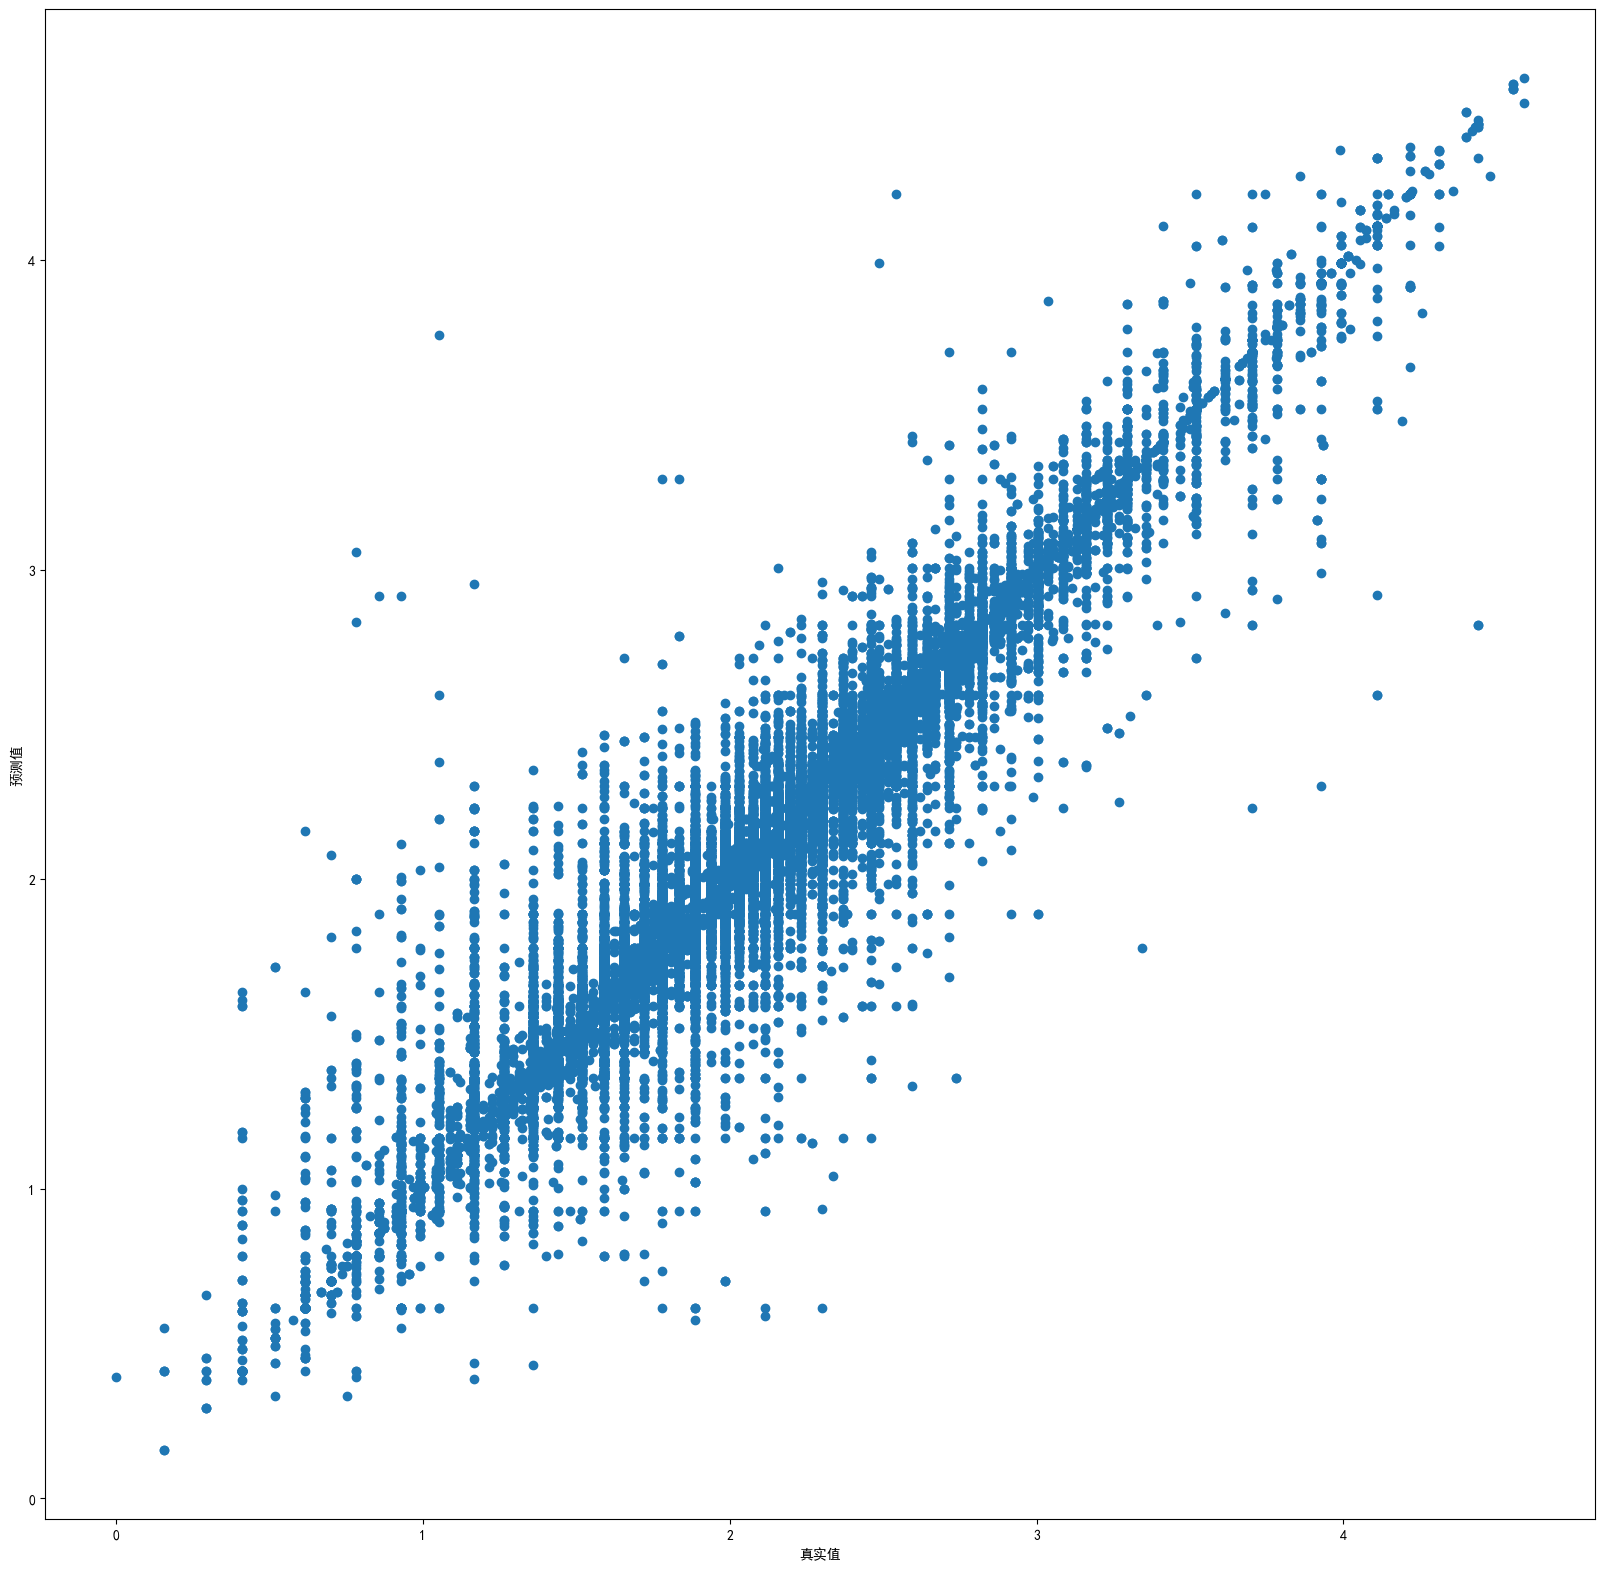

In [30]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,20),dpi=100)
plt.scatter(test_y,y_pred_test)
plt.xlabel("真实值")
plt.ylabel("预测值")
plt.show()

### 构建支持向量机

In [31]:
# #1.参数搜索----数据量大 svm太耗时，调参几乎不可能
# svr=SVR()
# params={
#     "gamma":[0.001,0.01,0.1,0.5,1,5],
#     "C":[0.001,0.1,0.5,1,5] 
# }
# model5=GridSearchCV(svr,param_grid=params,cv=5,n_jobs=-1,verbose=10)
# model5.fit(new_x_train,train_y)
# model5.best_params_

In [32]:
# #随意选一组参数   --- 耗时太长 放弃该模型
# svr=SVR(gamma=0.1,C=0.5)
# svr.fit(new_x_train,train_y)
# y_pred=svr.predict(new_x_test)
# rmse(test_y,y_pred)

### 构建xgboost模型

In [33]:
import xgboost as xgb
# params={
#     "objective":'reg:linear',
#     'eta':0.1,
#     'gamma': 0.05,
#     'silent': 1,
#     'max_depth':45, 
#     'min_child_weight':0.5,
#     'sub_sample':0.6,
#     'reg_alpha':0.5,
#     'reg_lambda':0.8,
#     'colsample_bytree':0.5
# }
# # 原生接口
# dtrain = xgb.DMatrix(x_train,train_y)
# dtest = xgb.DMatrix(x_test,test_y)
# bst = xgb.train(params, dtrain, num_boost_round=2000)

# sklearn接口
params={
    "objective":'reg:linear',
    'n_estimators': 500,
    'learning_rate':0.1,
    'gamma': 0.05,
    'silent': 1,
    'max_depth':45, 
    'min_child_weight':0.5,
    'sub_sample':0.6,
    'reg_alpha':0.5,
    'reg_lambda':0.8,
    'colsample_bytree':0.5
}
bst = xgb.XGBRegressor(**params)
bst.fit(x_train,train_y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=45,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0.5,
             reg_lambda=0.8, scale_pos_weight=1, silent=1, sub_sample=0.6,
             subsample=1, tree_method=None, validate_parameters=False,
             verbosity=None)

In [34]:
# 原生接口
# y_pred_test=bst.predict(dtest)
# y_pred_train=bst.predict(dtrain)

# sklearn接口
y_pred_test=bst.predict(x_test)
y_pred_train=bst.predict(x_train)
print("训练集rmse：",rmse(train_y,y_pred_train))
print("测试集rmse：",rmse(test_y,y_pred_test))

训练集rmse： 0.8807014222874057
测试集rmse： 1.3739418560534211


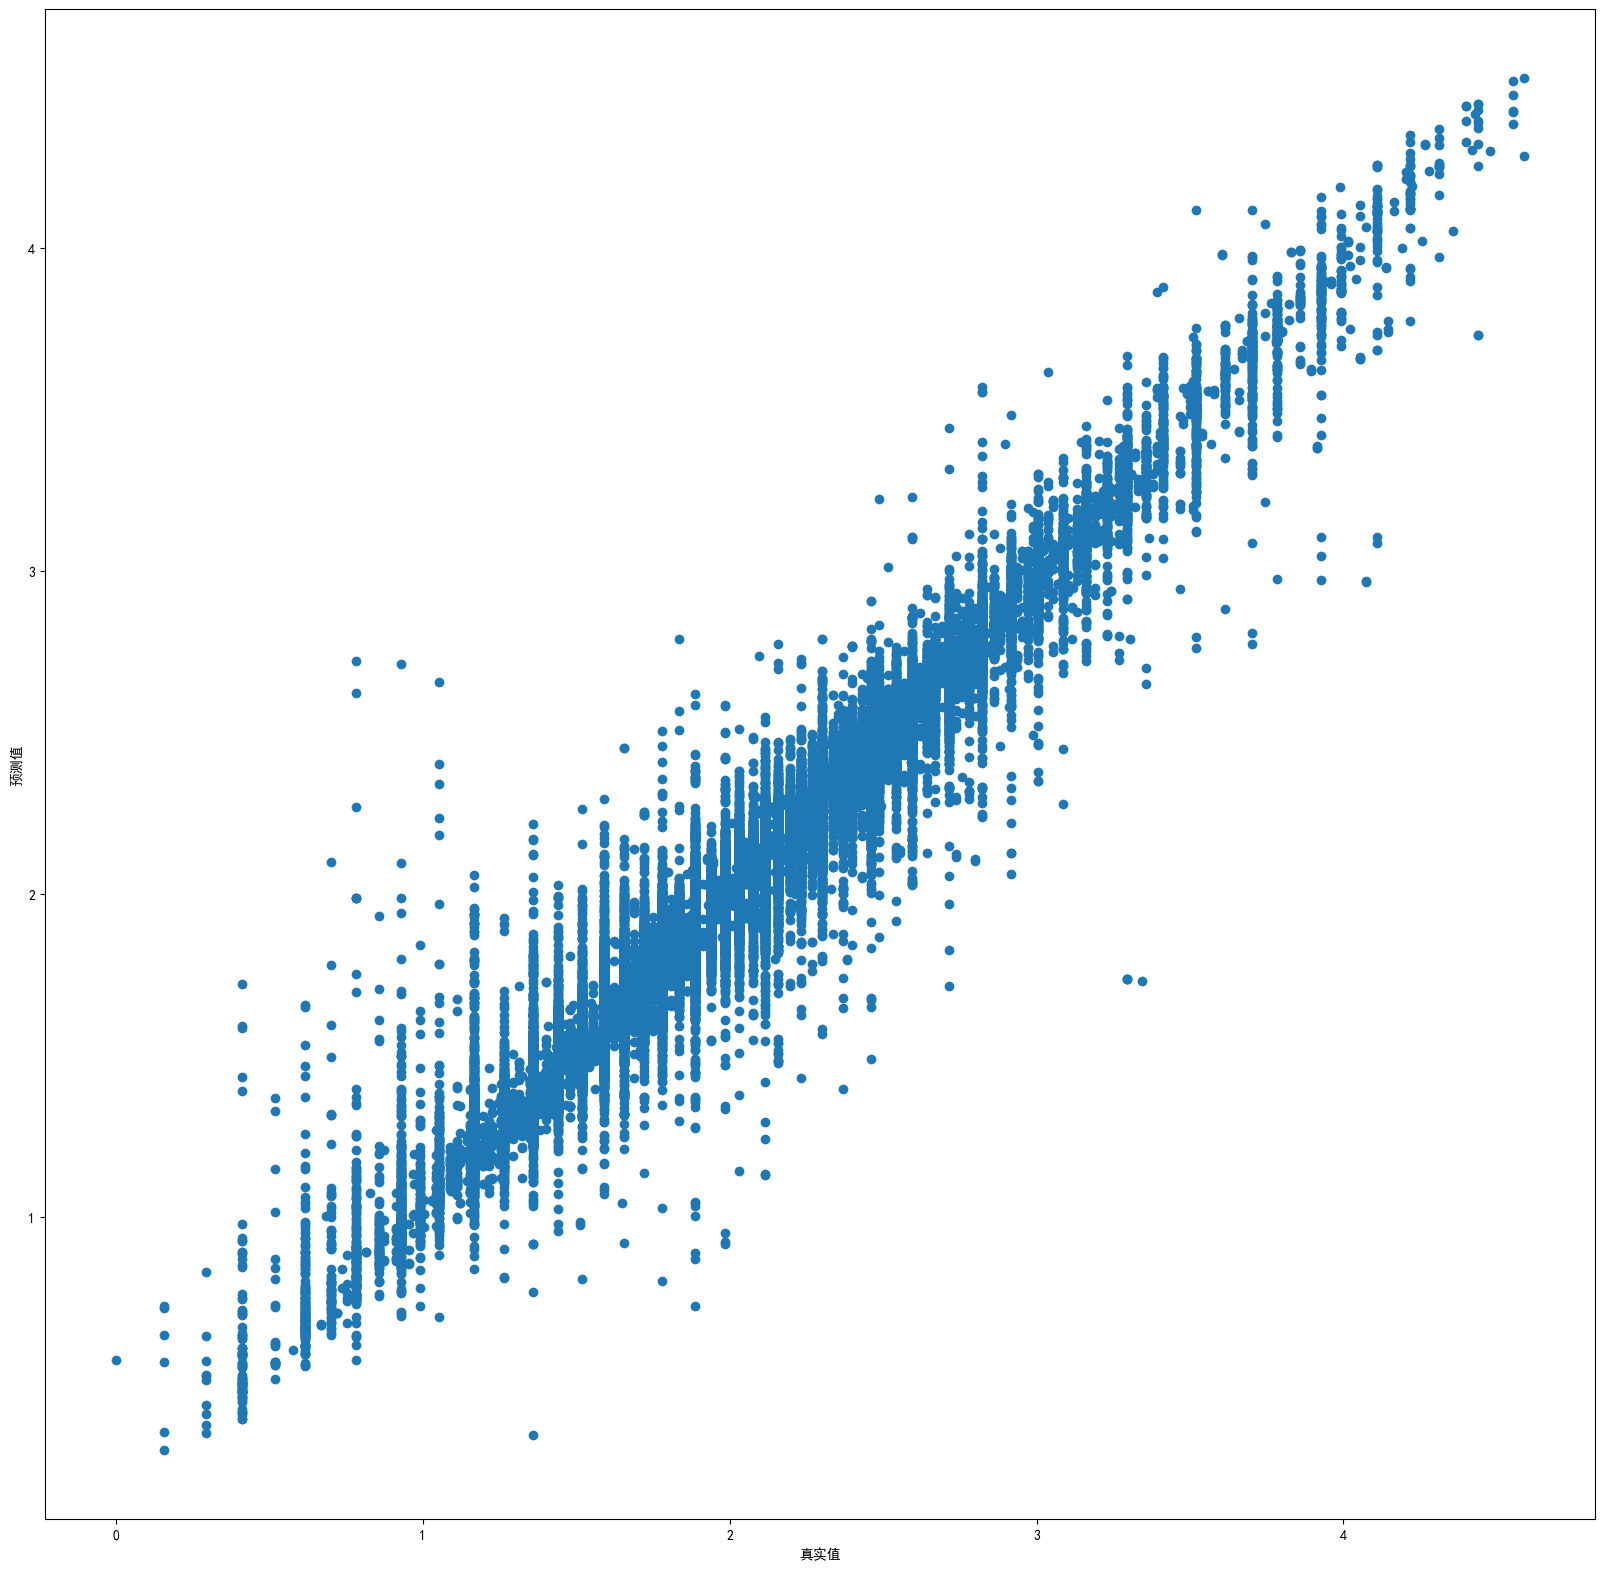

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20),dpi=100)
plt.scatter(test_y,y_pred_test)
plt.xlabel("真实值")
plt.ylabel("预测值")
plt.show()

## Stacking融合

In [42]:
#获取每个子模型的预测结果作为特征
train_features=[]
train_features.append(ridge.predict(new_x_train))#将每个模型预测值保存起来
train_features.append(lasso.predict(new_x_train))
# train_features.append(svr.predict(new_x_train))#这个太慢了  不要了
train_features.append(rf.predict(x_train))
train_features.append(tree.predict(x_train))
# train_features.append(bst.predict(dtrain))
train_features.append(bst.predict(x_train))

test_features=[]
test_features.append(ridge.predict(new_x_test))
test_features.append(lasso.predict(new_x_test))
# test_features.append(svr.predict(new_x_test))
test_features.append(rf.predict(x_test))
test_features.append(tree.predict(x_test))
# test_features.append(bst.predict(dtest))
test_features.append(bst.predict(x_test))

In [43]:
# 构建新的训练集和测试集
mx_train=np.vstack(train_features).T
mx_test=np.vstack(test_features).T
mx_train.shape

(137549, 5)

In [44]:
# 搜索最优参数
stack_model=Ridge(fit_intercept=False)
params={
    "alpha":np.logspace(-2,3,20)
}
model=GridSearchCV(stack_model,param_grid=params,cv=5,n_jobs=-1)
model.fit(mx_train,train_y)
model.best_params_

{'alpha': 0.37926901907322497}

In [39]:
# 根据选出的参数进行训练
stack_model=Ridge(alpha=0.379,fit_intercept=False)
stack_model.fit(mx_train,train_y)
y_pred_test=stack_model.predict(mx_test)
y_pred_train=stack_model.predict(mx_train)
print("训练集rmse：",rmse(train_y,y_pred_train))
print("测试集rmse：",rmse(test_y,y_pred_test))

训练集rmse： 0.6882801335592807
测试集rmse： 1.4333324034396449


In [40]:
stack_model.coef_

array([-0.04130443,  0.03826403, -0.162642  ,  0.67926653,  0.48640027])

## 模型保存

In [41]:
import pickle

with open("data/model.pkl","wb") as f:
    pickle.dump({
        "vector":vector,
        "pca":pca,
        "sc":trans,
        "ridge":ridge,
        "lasso":lasso,
        "rf":rf,
        "tree":tree,
        "bst":bst,
        "stack":stack_model
    },f)